# PARALLELISM

## 1. Многопоточность. Thread Python

### 1.1. Знакомство с потоками и процессами

Процесс - это наша основная программа. Потоки запускаются внутри нашего процесса. То есть может быть один процесс, а внутри него запущено несколько потоков.
При этом процессы могут выполняться истинно параллельно, в то время как потоки истинно параллельно выполняться не могут.

Потоки можно использовать тогда, когда необходимо выполнение кода в фоновом режиме, например, проверка ключча активации.
Если же нужна скорость и можно пожерствовать ресурсами, лучше использовать процессы для обеспенения истинноо параллелизма в <b>Python</b>.

Вот пример кода с использованием многопоточности:

In [ ]:
import threading
import time


def get_data(data):
    print(f'[{threading.current_thread().name}] - {data}')
    time.sleep(5)


thr = threading.Thread(target=get_data, args=(str(time.time()), ), name='thr-1')
''' в targer передается ссылка на функцию, в args - текущее время в формате unix.
В args передаются аргументы целевой функции, переданной в target '''

thr.start()

for i in range(100):
    print(f'current: {i}')
    time.sleep(0.5)

    if i % 10 == 0:
        print(f'Active thread: {threading.active_count()}') # вывод количества активных потоков
        print(f'enumerate: {threading.enumerate()}') # вывод всех потоков, которые запущены в данный момент времени
        print(f'thr-1 is alive: {thr.is_alive()}') # проверяем, работает ли наш поток в данный момент
        print(threading.main_thread()) # вывод основного потока выполнения

        print(f'name: {threading.main_thread().name}') # получение имени основного потока
        threading.main_thread().setName('result') # изменение имени основного потока
        print(f'name: {threading.main_thread().name}')



#### Join

Метод `join` позволяет дожидаться выполнения нашего потока.
Предположим, нам нужно запустить около двадцати потоков, дождаться выполнения и только после того, как наши потоки выполняются, только тогда мы продолжаем выполнять наш код.

In [ ]:
import threading
import time


def get_data(data, value):
    for _ in range(value):
        print(f'[{threading.current_thread().name}] - {data}')
        time.sleep(1)

# список, в котором храним объекты всех потоков
# thr_list = []


for i in range(4): # создание трех итераций, чем создаем три потока
    thr = threading.Thread(target=get_data, args=(str(time.time()), i, ), name=f'thr-{i}')
    # thr_list.append(thr)
    thr.start() # данный вывод у нас не блокируется
    # print(thr_list)

for i in thr_list:
    i.join() # методом join мы ждем, пока не выполнится данный поток
             # то есть изначально мы ждем, пока выполнится поток с индексом 0, потом 1, потом 2
             # код на данной строчке блокируется, тем самым не будет выполняться дальше

print('finish')

### 1.2. Принцип работы Deamon Thread

Получается, что наш основной поток уже завершил выполнение своего кода, так как вывелось `finish`.
Но наш поток продолжает выполнение своего кода и выполняет `print`.

Для того, завершить все потоки, когда завершается основной поток (вся программа), нужно использовать атрибут `demon`, который принимает либо `True` либо `False`. Если `True`, завершаются все потоки, когда завершает свою работу основной поток.

In [ ]:
import threading
import time


def get_data(data):
    for _ in range(5):
        print(f'[{threading.current_thread().name}] - {data}')
        time.sleep(1)

thr = threading.Thread(target=get_data, args=(str(time.time()),), daemon=True)
thr.start()
print('finish')

'''
>>> [Thread-1 (get_data)] - 1688251603.8985856
>>> finish
'''

Перед выполнением потока можно обратитсья к потоку и задать ему значение `daemon`:

In [ ]:
import threading
import time


def get_data(data):
    for _ in range(5):
        print(f'[{threading.current_thread().name}] - {data}')
        time.sleep(1)

thr = threading.Thread(target=get_data, args=(str(time.time()),))
thr.setDaemon(True) # присваиваем потоку значение True
thr.start()
print('finish')

'''
>>> [Thread-1 (get_data)] - 1688252148.2741547
>>> finish
'''

### 1.3. Синхронизация потоков. Блокировщики Lock и RLock

Снизу в примере можно предположить, что даннные потоки будут выполняться последовательно, то есть сначала мы получим 1, потом 2, 3 и т.д.

In [ ]:
import time
import threading

value = 0

def inc_value():
    global value
    while True: # в бесконечном цикле увеличиваем глобальную переменную на 1
        value += 1
        time.sleep(1)
        print(value)

for _ in range(5): # запускаем пять потоков, которые будут выполнять данную задачу
    threading.Thread(target=inc_value).start()

Получился такой неожиданный результат. Творится полнейший хаос.
Для того, чтобы такого не было, существуют две блокировки `Lock()` и `Erlock`.

`Lock`:

In [ ]:
import time
import threading

value = 0
locker = threading.Lock() # создаем объект нашего блокировщика

def inc_value():
    global value
    while True:
        locker.acquire() # используем метод для того, чтобы заблокировать доступ остальным потокам к области ниже
        value += 1                 # поток, который первый вызовет данный метод, получит доступ к данной области
        time.sleep(1)
        print(value)
        locker.release() # освобождаем данную область от блокировки

for _ in range(5):
    threading.Thread(target=inc_value).start()

Как видно потоки синхронно изменяют наше значение. То есть оно выполняется полседовательно, так как только один поток может вмешаться в область памяти, где к переменной `value` прибавляется `1`.

Также можно использовать контекстный менеджер:

In [ ]:
import time
import threading

value = 0
locker = threading.Lock() # создаем объект нашего блокировщика

def inc_value():
    global value
    while True:
        with locker: # добавляем контекстный менеджер
            value += 1
            time.sleep(0.1)
            print(value)

for _ in range(5):
    threading.Thread(target=inc_value).start()

Также данные изменяются последовательно.

Вот более наглядный пример:

In [ ]:
import threading

locker = threading.Lock()

def inc_value():
    print('Блокируем поток')
    locker.acquire()
    print('Поток разблокирован')


t1 = threading.Thread(target=inc_value)
t2 = threading.Thread(target=inc_value)

t1.start()
t2.start()

Как видно, второй поток не выполняется, так как первый применил блокировку.
При этом `Lock()` может быть заблокирован и разблокирован из абсолютно любого потока.
То есть блокировку можно сделать, наприер, в `t1`, а разблокировать в `t2`.

При этом, если есть код, который обязательно должен выполняться синхронно, нужно использовать `RLock()`:

In [ ]:
import threading

locker = threading.RLock() # добавляем RLock()

def inc_value():
    print('Блокируем поток')
    locker.acquire()
    print('Поток разблокирован')


t1 = threading.Thread(target=inc_value)
t2 = threading.Thread(target=inc_value)

t1.start()
t2.start()

Как видно, также заблокирован фрагмент кода.
При использовании `RLock()` разблокировать замок может только тот поток, который его заблокировал.
Сравнение: у вас есть замок, ключ к которому есть только у вас.

### 1.4. Класс Timer и хранилище Local

В этом уроке будут рассмотрены таймеры, а также технологии для передачи данных между потокам.
С помощью таймеров мы можем запускать потоки спустя заданное время.

Вот пример:

In [1]:
import time
import threading

def test():
    while True:
        print('Test')
        time.sleep(1)

threading.Timer(interval=10, function=test).start()

while True:
    print('111')
    time.sleep(2)

111
111
111
111
111
Test
111
Test
111
Test


Test
111
Test


Как видно, сначала 10 секунд выполнялся основной поток и выводилось `111`. И только после 10 секунд другой поток начал выполнение функции `test`.

В классе `Timer()` также присутствует метод, чтобы отменить запуск потока до его выполнения. Пример:

In [1]:
import time
import threading

def test():
    while True:
        print('Test')
        time.sleep(1)

thr = threading.Timer(interval=5, function=test)

for _ in range(3):
    print('111')
    time.sleep(1)

thr.cancel()
print('finish')

111
111
111
finish


В данном примере, когда основной поток дошел до `thr.cancel()` (дошел спустя три секунды) выполнение потока было отменено до его запуска с помощью `thr.cancel()`.

Также мы можем обратиться к атрибуту `daemon`, чтобы завершить все потоки после завершения выполнения основного потока.
Вот пример:

In [1]:
import time
import threading

def test():
    while True:
        print('Test')
        time.sleep(1)

thr = threading.Timer(interval=5, function=test)
thr.setDaemon(True)                                 # определяем daemon
thr.start()

for _ in range(6):
    print('111')
    time.sleep(1)

print('finish')

c:\temp1\ipykernel_6676\2460821053.py:10: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  thr.setDaemon(True)


111
111
111
111
111
Test
111
Test
finish


Как видно, после выполнения основного потока все остальные потоки также завершили свое выполнение.

`local`  
`local` позволяет хранить данные в наших потоках и задавать нужные атрибуты, а также задавать значение данным атрибутам. 

In [3]:
import threading
import time

data = threading.local() # определяем local

def get():
    print(data.value)
    
def t1():
    data.value = 111 # значение будет доступно только в данном потоке
    get()

def t2():
    data.value = 222 # это значение также будет доступно только в данном потоке
    get()

threading.Thread(target=t1).start()
threading.Thread(target=t2).start()

111
222


Стоит отметить, что обратиться к атриубутам, заданным в каких-то потоках, мо мыожем только из этих потоков.
При как видно, у нас есть доступ к `data`, которые определены вне нашего потока но запускаются из него.

Другой пример:

In [4]:
import threading

data = threading.local()
    
def t1():
    data.value = 111
    print(f't1:', data.value)

def t2():
    data.test = 222
    print(f't2:', data.test)

threading.Thread(target=t1).start()
threading.Thread(target=t2).start()

t1: 111
t2: 222


Также мы сами придуваем имена атрибутам и задаем им любые типы данных.
Пример:

In [6]:
import threading

data = threading.local()
    
def t1():
    data.value = {'data': 111}
    print(f't1:', data.value)

def t2():
    data.test = [1, 2, 3]
    print(f't2:', data.test)

threading.Thread(target=t1).start()
threading.Thread(target=t2).start()

t1: {'data': 111}
t2: [1, 2, 3]


Другой пример:

In [1]:
import threading

data = threading.local()

def get_name(): # функция, которая просто выводит атрибут name
    print(data.name)

def t1():
    data.name = threading.current_thread().name # получает текущее имя потока и присваивает его атрибуту name
    get_name() # вызывает функцию для вывода атрибута с именем name

def t2(): # далает то же самое, что и предыдущая функция
    data.name = threading.current_thread().name
    get_name()

threading.Thread(target=t1, name='t1').start()
threading.Thread(target=t2, name='t2').start()

t1
t2


Обратите внимание, что фунцию `get_name()` мы вызываем из локальной области, то есть из потоков, который запускает фунции `t1()` и `t2()`, тем самым данные потоки получают доступ к локальной области `local()`.

Вот что будет, если мы обатимся к атрибуту `local()` из основного потока, а не из локального:

In [2]:
import threading

data = threading.local()

def get_name(): # функция, которая просто выводит атрибут name
    print(data.name)

def t1():
    data.name = threading.current_thread().name # получает текущее имя потока и присваивает его атрибуту name
    time.sleep(100)

threading.Thread(target=t1, name='t1').start()
time.sleep(2)
get_name()


Exception in thread t1:
Traceback (most recent call last):
  File "C:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\temp1\ipykernel_13832\1589881982.py", line 10, in t1
    time.sleep(100)
    ^^^^
NameError: name 'time' is not defined


NameError: name 'time' is not defined

Как видно атрибут `local()` с именем `name` не определен.

### 1.5. Семафоры и Барьеры

Семафоры и Барьеры служат для синхронизации барьеров.

Семафор - это технология, в основе которой лежит счетчик. Семафор позволяет заранее указать макисмальное значение счетчика. Когда потоков, которые попытаются получить семафор, будут больше этого значения, он заблокируется.
То есть если мы счетчику семафора присвоим значение `5`, а потоков у нас будет `10`, то пяти потокам из них нужно будет ждать свою очередь.
Если один из потоков завершит свое выполнение, одно место освоболится в семафоре, из-за чего следующий, `6` поток начнет свое выполнение.
Таким образом, семафор - это численное значение, указывающее на количество одновременно выполняемых потоков при выполнении основного потока.

Пример:

In [5]:
from threading import Thread, BoundedSemaphore, current_thread
import time

max_connections = 5 # переменная с максимальный количеством потоков
pool = BoundedSemaphore(value=max_connections) # создаем объект BoundedSemaphore и присваиваем ему значение с максимальный количеством потоков

def test():
    while True:
        with pool:
            print(current_thread().name)
            time.sleep(2)

Thread(target=test).start()

Thread-11 (test)


Thread-11 (test)
Thread-11 (test)
Thread-11 (test)
Thread-11 (test)
Thread-11 (test)
Thread-11 (test)
Thread-11 (test)


В следующем примере создадим большее количество потоков, чем принял `BoundedSemaphore`:

In [4]:
from threading import Thread, BoundedSemaphore, current_thread
import time, datetime

max_connections = 5 # переменная с максимальный количеством потоков
pool = BoundedSemaphore(value=max_connections) # создаем объект BoundedSemaphore и присваиваем ему значение с максимальный количеством потоков

def test():
    with pool:
        print(current_thread().name, datetime.datetime.now().strftime('%H:%M:%S'))
        time.sleep(6)

for i in range(10):
    Thread(target=test, name=f'thr-{i}').start()

thr-0 12:35:44
thr-1 12:35:44
thr-2 12:35:44
thr-3 12:35:44
thr-4 12:35:44


thr-5thr-6 12:35:50
thr-7 12:35:50
thr-8 12:35:50
thr-9 12:35:50
 12:35:50


Как видно, сначала одновременно сработало 5 потоков. После их выполнения сработали остальные потоки. При это каждый раз одновременно выполнялось не более пяти потоков.

В следующем примере увеличим количество потоков:

In [5]:
from threading import Thread, BoundedSemaphore, current_thread
import time, datetime

max_connections = 5 # переменная с максимальный количеством потоков
pool = BoundedSemaphore(value=max_connections) # создаем объект BoundedSemaphore и присваиваем ему значение с максимальный количеством потоков

def test():
    with pool:
        print(current_thread().name, datetime.datetime.now().strftime('%H:%M:%S'))
        time.sleep(5)

for i in range(20):
    Thread(target=test, name=f'thr-{i}').start()

thr-0 12:38:43
thr-1 12:38:43
thr-2 12:38:43
thr-3 12:38:43
thr-4 12:38:43


thr-5thr-6 12:38:48
thr-7 12:38:48
thr-8 12:38:48
thr-9 12:38:48
 12:38:48
thr-10thr-11 12:38:53
thr-12 12:38:53
thr-13 12:38:53
thr-14 12:38:53
 12:38:53
thr-15thr-16 12:38:58
thr-17 12:38:58
thr-18 12:38:58
thr-19 12:38:58
 12:38:58


`barier`  
`barier` - это противоположная семафору технология.
В данном случае мы также указываем количество активных потоков, но только когда они запускаются, когда они дойдут до вызова метода `wait()`, после чего будут ждать, пока эти пять потоков не вызовут этот метод `wait()`. Только после того, как все указанные потоки его вызвали, мы разбокируемся и продолжим его выполнение.

Пример:

In [7]:
from threading import current_thread
import threading
import time, random

def test(barier):
    slp = random.randint(3, 7)
    print(f'Поток [{current_thread().name}] запущен в ({time.ctime()})')

    barier.wait() # вызываем метод wiat(), который ждет, пока количество указанных потоков будут запущен
    print(f'Поток [{current_thread().name}] преодалел барьер ({time.ctime()})')

bar = threading.Barrier(parties=5) # создаем объект Barrier и указываем кол-во одновременно работающих потоков=5

for i in range(5): # создаем 5 потоков
    threading.Thread(target=test, args=(bar, ), name=f'thr-{i}').start()





Поток [thr-0] запущен в (Sun Jul  2 12:52:49 2023)Поток [thr-1] запущен в (Sun Jul  2 12:52:49 2023)

Поток [thr-2] запущен в (Sun Jul  2 12:52:49 2023)
Поток [thr-3] запущен в (Sun Jul  2 12:52:49 2023)
Поток [thr-4] запущен в (Sun Jul  2 12:52:49 2023)
Поток [thr-4] преодалел барьер (Sun Jul  2 12:52:49 2023)
Поток [thr-0] преодалел барьер (Sun Jul  2 12:52:49 2023)Поток [thr-1] преодалел барьер (Sun Jul  2 12:52:49 2023)
Поток [thr-3] преодалел барьер (Sun Jul  2 12:52:49 2023)

Поток [thr-2] преодалел барьер (Sun Jul  2 12:52:49 2023)


В данном примере пять потоков запустились одновременно, после чего на методе `barier.wait()` приостановили свое выполнение и ожидали, пока все потоки не дойдут до `barier.wait()`. Когда все потоки дошшли до `barier.wait()`, все они продолжили свое выполнение.

### 1.6. Технологии Condition, Event

`Condition` и `Event` позволяют использовать сигналы и передавать их между разными потоками. То есть это позволяет сделать общение медлу потоками.

Используя `Condition` мы можем установить выполнение нужного нам потока в определенном месте. И его выполнение не продолжится, пока любой из потоков не сообщит ему об этом.
`Event` работает по такому же принципу, но у них есть только одно базовое состояние: `False` - значение по умолчанию, либо `False`, которое говорит о том, что нужно начать выполнеине.

Вот пример с `Event`:

In [5]:
import threading
import time

event = threading.Event() # создаем экземпляр класса Event()

def test():
    while True:
        print(threading.active_count()) # количество активных потоков
        print(threading.enumerate()) # список активных потоков
        print(event.is_set()) # в каком значении установлен объект Event()
        event.wait()    # метод сработает, только если в Event() хранится значение True
                        # при этом поток не может пойти дальше метода wait(), так как по умолчанию в Event() хранится False
        print('test')
        time.sleep(2)

event.clear() # сбрасываем значение Event() к значению False
threading.Thread(target=test).start()

11
[<_MainThread(MainThread, started 24332)>, <Thread(IOPub, started daemon 24440)>, <Heartbeat(Heartbeat, started daemon 18844)>, <ControlThread(Control, started daemon 12404)>, <HistorySavingThread(IPythonHistorySavingThread, started 22876)>, <ParentPollerWindows(Thread-4, started daemon 23932)>, <Thread(Thread-5 (test), started 24192)>, <Thread(Thread-6 (test), started 18144)>, <Thread(Thread-7 (test), started 12692)>, <Thread(Thread-8 (test), started 18596)>, <Thread(Thread-9 (test), started 11776)>]
False


Как видно, поток дальше `event.wait()` не продолжает выполнение.
Для того, чтобы продолжить выполнение, нужно передать потоку `event.set()`.  
Пример:

In [7]:
import threading
import time

event = threading.Event() # создаем экземпляр класса Event()

def test():
    while True:
        print(threading.active_count())
        print(threading.enumerate())
        print(event.is_set())
        event.wait()    

        print('test')
        time.sleep(2)

event.clear() # сбрасываем значение Event() к значению False
threading.Thread(target=test).start()
event.set() # передаем в объект Event() Значение True

13
[<_MainThread(MainThread, started 24332)>, <Thread(IOPub, started daemon 24440)>, <Heartbeat(Heartbeat, started daemon 18844)>, <ControlThread(Control, started daemon 12404)>, <HistorySavingThread(IPythonHistorySavingThread, started 22876)>, <ParentPollerWindows(Thread-4, started daemon 23932)>, <Thread(Thread-5 (test), started 24192)>, <Thread(Thread-6 (test), started 18144)>, <Thread(Thread-7 (test), started 12692)>, <Thread(Thread-8 (test), started 18596)>, <Thread(Thread-9 (test), started 11776)>, <Thread(Thread-10 (test), started 9504)>, <Thread(Thread-11 (test), started 4544)>]
True
test


13
[<_MainThread(MainThread, started 24332)>, <Thread(IOPub, started daemon 24440)>, <Heartbeat(Heartbeat, started daemon 18844)>, <ControlThread(Control, started daemon 12404)>, <HistorySavingThread(IPythonHistorySavingThread, started 22876)>, <ParentPollerWindows(Thread-4, started daemon 23932)>, <Thread(Thread-5 (test), started 24192)>, <Thread(Thread-6 (test), started 18144)>, <Thread(Thread-7 (test), started 12692)>, <Thread(Thread-8 (test), started 18596)>, <Thread(Thread-9 (test), started 11776)>, <Thread(Thread-10 (test), started 9504)>, <Thread(Thread-11 (test), started 4544)>]
True
test
13
[<_MainThread(MainThread, started 24332)>, <Thread(IOPub, started daemon 24440)>, <Heartbeat(Heartbeat, started daemon 18844)>, <ControlThread(Control, started daemon 12404)>, <HistorySavingThread(IPythonHistorySavingThread, started 22876)>, <ParentPollerWindows(Thread-4, started daemon 23932)>, <Thread(Thread-5 (test), started 24192)>, <Thread(Thread-6 (test), started 18144)>, <Thread(Thre

Как видно, выполняется сначала сорзданный нами поток, а когда он доходит до `event.wait()`, ожмдает сигнал `True` для `Event()`, после чего продолжает выполнение основного потока.

Еще пример:

In [2]:
import threading
import time

event = threading.Event() # создаем экземпляр класса Event()

def image_handler():
    thr_name = threading.current_thread().name
    print(f'Идет подготовка изображения для потока [{thr_name}], {time.ctime}')
    event.wait()
    print(f'Изображение отправлено, {time.ctime}')


for i in range(10):
    thr_name = f'[thr-{i}]'
    threading.Thread(target=image_handler, name=thr_name).start()
    print(f'Поток {thr_name} запущен')
    time.sleep(1)


if threading.active_count() >= 10:
    event.set()

Идет подготовка изображения для потока [[thr-0]], <built-in function ctime>Поток [thr-0] запущен

Идет подготовка изображения для потока [[thr-1]], <built-in function ctime>Поток [thr-1] запущен

Идет подготовка изображения для потока [[thr-2]], <built-in function ctime>Поток [thr-2] запущен

Идет подготовка изображения для потока [[thr-3]], <built-in function ctime>Поток [thr-3] запущен

Идет подготовка изображения для потока [[thr-4]], <built-in function ctime>Поток [thr-4] запущен

Идет подготовка изображения для потока [[thr-5]], <built-in function ctime>Поток [thr-5] запущен

Идет подготовка изображения для потока [[thr-6]], <built-in function ctime>Поток [thr-6] запущен

Идет подготовка изображения для потока [[thr-7]], <built-in function ctime>Поток [thr-7] запущен

Идет подготовка изображения для потока [[thr-8]], <built-in function ctime>Поток [thr-8] запущен

Идет подготовка изображения для потока [[thr-9]], <built-in function ctime>Поток [thr-9] запущен

Изображение отправле

Как видно, сначала запустились все потоки. После чего каждый из потоков достиг `event.wait()`. После этого основной поток продолжил свое выполнения, вызывая новые потоки. Когда все потоки, количество которых было передано в `range`, были вызваны, основной поток продолжил свое выполнение и дошел до `event.set()`, который передал в объект `Event()` значение `True`. После этого все потоки продолжили свое выполнение, дойдя до конца функции, то есть до `print(f'Изображение отправлено, {time.ctime}')`.

Мы также можем давать уведомление `True` одному потому либо всем потокам.

Еще пример:

In [1]:
import threading
import time


cond = threading.Condition() # создаем объект Condition()


def f1():
    while True:
        with cond:
            cond.wait() # вызываем метод wait()
            print(f'Получили событие!, time: {time.localtime()}')


def f2():
    for i in range(100):
        if i % 10 == 0:
            with cond:
                cond.notify() # вызываем notify()
        else:
            print(f'f1: {i}')
            time.sleep(1)


threading.Thread(target=f1).start()
threading.Thread(target=f2).start()

f1: 1
Получили событие!, time: time.struct_time(tm_year=2023, tm_mon=7, tm_mday=2, tm_hour=22, tm_min=4, tm_sec=35, tm_wday=6, tm_yday=183, tm_isdst=0)


f1: 2
f1: 3
f1: 4
f1: 5
f1: 6
f1: 7
f1: 8
f1: 9
f1: 11Получили событие!, time: time.struct_time(tm_year=2023, tm_mon=7, tm_mday=2, tm_hour=22, tm_min=4, tm_sec=44, tm_wday=6, tm_yday=183, tm_isdst=0)

f1: 12
f1: 13
f1: 14
f1: 15
f1: 16
f1: 17
f1: 18
f1: 19
f1: 21Получили событие!, time: time.struct_time(tm_year=2023, tm_mon=7, tm_mday=2, tm_hour=22, tm_min=4, tm_sec=53, tm_wday=6, tm_yday=183, tm_isdst=0)

f1: 22
f1: 23
f1: 24
f1: 25
f1: 26
f1: 27
f1: 28
f1: 29
f1: 31Получили событие!, time: time.struct_time(tm_year=2023, tm_mon=7, tm_mday=2, tm_hour=22, tm_min=5, tm_sec=2, tm_wday=6, tm_yday=183, tm_isdst=0)

f1: 32
f1: 33
f1: 34
f1: 35


На данном примере два потока начали свое выполнение одновременно. Поток `threading.Thread(target=f1).start()` встречает метод `cond.wait()`, который приостанавливает его выполнение. В то время как поток `threading.Thread(target=f1).start()` выполняется. Когда в данном потоке интерпертатор встречает `cond.notify()`, тем самым сообщая объекту `Condition()` что нужно продолжить выполнение приостановленного потока `threading.Thread(target=f1).start()`.

Отличие `Event()` И `Condition()` заключается в том, что в `Event()` если мы присваивали его объекту значение `True`, оно сохраналось до тех пор, пока мы сами не зададим ему значение `False`. В `Condition()` значение объект `True()` автоматически меняется на `False`, после `notify()`.

В данном случае `notify()` в `Condition()` это аналог `set()` в `Event()`.

Такой же пример с `Event()`:

In [1]:
import threading
import time


cond = threading.Event() # создаем объект Event()


def f1():
    while True:
        cond.wait() # вызываем метод wait()
        print(f'Получили событие!, time: {time.localtime()}')
        time.sleep(1.5)


def f2():
    for i in range(100):
        if i % 10 == 0:
            cond.set() # вызываем set()
        else:
            print(f'f1: {i}')
            time.sleep(1.5)


threading.Thread(target=f1).start()
threading.Thread(target=f2).start()

f1: 1
Получили событие!, time: time.struct_time(tm_year=2023, tm_mon=7, tm_mday=2, tm_hour=22, tm_min=18, tm_sec=34, tm_wday=6, tm_yday=183, tm_isdst=0)


f1: 2Получили событие!, time: time.struct_time(tm_year=2023, tm_mon=7, tm_mday=2, tm_hour=22, tm_min=18, tm_sec=36, tm_wday=6, tm_yday=183, tm_isdst=0)

Получили событие!, time: time.struct_time(tm_year=2023, tm_mon=7, tm_mday=2, tm_hour=22, tm_min=18, tm_sec=37, tm_wday=6, tm_yday=183, tm_isdst=0)f1: 3

Получили событие!, time: time.struct_time(tm_year=2023, tm_mon=7, tm_mday=2, tm_hour=22, tm_min=18, tm_sec=39, tm_wday=6, tm_yday=183, tm_isdst=0)f1: 4

f1: 5
Получили событие!, time: time.struct_time(tm_year=2023, tm_mon=7, tm_mday=2, tm_hour=22, tm_min=18, tm_sec=40, tm_wday=6, tm_yday=183, tm_isdst=0)
f1: 6Получили событие!, time: time.struct_time(tm_year=2023, tm_mon=7, tm_mday=2, tm_hour=22, tm_min=18, tm_sec=42, tm_wday=6, tm_yday=183, tm_isdst=0)

Получили событие!, time: time.struct_time(tm_year=2023, tm_mon=7, tm_mday=2, tm_hour=22, tm_min=18, tm_sec=43, tm_wday=6, tm_yday=183, tm_isdst=0)
f1: 7
f1: 8Получили событие!, time: time.struct_time(tm_year=2023, tm_mon=7, tm_mday=2, 

Как видно на примере, для `Event()` значание всегда остается в `True`.

При этом обратите внимание, что для работы с `Condition()` использовался контекстый менеджер `with`.



## 2. Многопроцессность. Multiprocessing Python

### 2.1. Основы при работе с процессами

Для того, чтобы подключать процессы в Python, нужно использовать модуль `multiproccesing`.

Вот пример:

In [ ]:
import multiprocessing
from multiprocessing import set_start_method
import time
import sys


def test():
    while True:
        print('test: ', multiprocessing.current_process(), time.strftime("%H:%M:%S"), flush=True)
        # sys.stdout.flush()
        time.sleep(1)


if __name__ == '__main__':
    multiprocessing.Process(target=test, name='prc-1').start()
    multiprocessing.Process(target=test, name='prc-2').start()
    print('Процесс запущен')

Вывод:
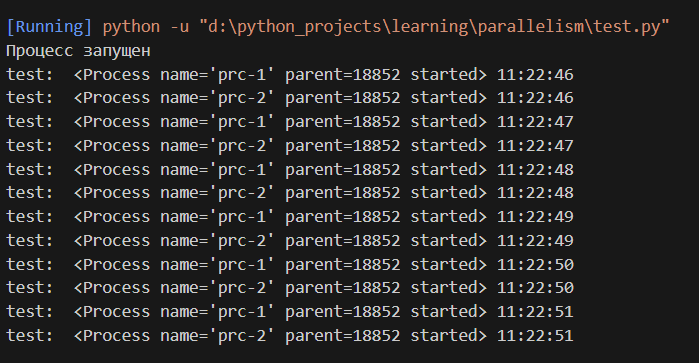

Рассмотрим атрибуты, которые хранит процесс:

In [ ]:
import multiprocessing
from multiprocessing import set_start_method
import time
import sys


def test():
    while True:
        print('test: ', multiprocessing.current_process(), time.strftime("%H:%M:%S"), flush=True)
        time.sleep(1)


if __name__ == '__main__':
    prc1 = multiprocessing.Process(target=test, name='prc-1')
    prc1.start()

    print(prc1.is_alive()) # работает ли наш процесс
    print(prc1.pid, flush=True) # получение ID процесса. Мы можем также обращаться к данному ID и модифицировать нащ процесс
    time.sleep(5)
    prc1.terminate() # безопасно убить процесс

Вывод:  
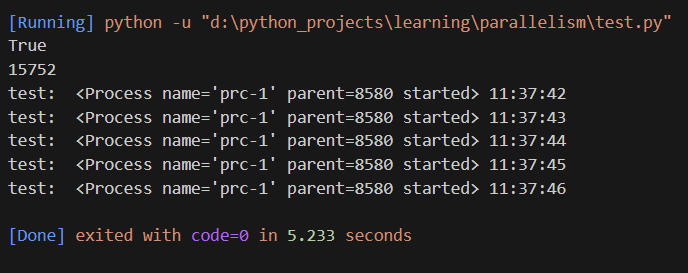

В данном примере мы использовали `prc1.is_alive()` для получения информации, запущен ли нащ процесс. Флаг `True` означает, что процесс запущен.  
`prc1.pid` - получение ID процесса.  
`prc1.terminate()` - безопасно завершить процесс.

Часто используют метод `join()`.  
`join()` не позволяет интерпретатору основного процесса опуститься ниже данной строчки, пока созданный нами процесс не будет завершен.

Вот пример:

In [ ]:
import multiprocessing
from multiprocessing import set_start_method
import time
import sys


def test():
    for _ in range(3):
        print('test: ', multiprocessing.current_process(), time.strftime("%H:%M:%S"), flush=True)
        time.sleep(1)


if __name__ == '__main__':
    prc1 = multiprocessing.Process(target=test, name='prc-1')
    prc1.start()
    prc1.join() # вызываем метод join()
    print('Все процессы завершены', flush=True)

Вывод:  
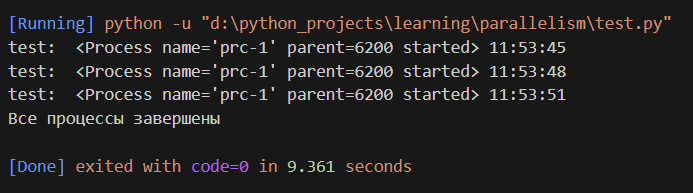

Как видно на примере, сначала завершился процесс, а только потом продолжил выполнение основной процесс интерпретатора Python.

Запустим несколько процессов и запустим метод `join()` для каждого из них.
Пример:

In [ ]:
import multiprocessing
import time
from datetime import datetime


def test():
    for _ in range(3):
        print('test: ', multiprocessing.current_process(), datetime.utcnow().strftime('%F %T.%f')[:-3], flush=True)
        time.sleep(3)

prc = []

if __name__ == '__main__':
    for i in range(3): # создаем три процесса, которые будут выполнять функцию test() 
        pr = multiprocessing.Process(target=test)
        prc.append(pr) # помещаем процесс в список для процессов
        pr.start()

for i in prc: # бежим по списку и ожидаем, пока все процессы из списка у нас закончатся
    i.join()

print('Все процессы завершены')

Вывод:  
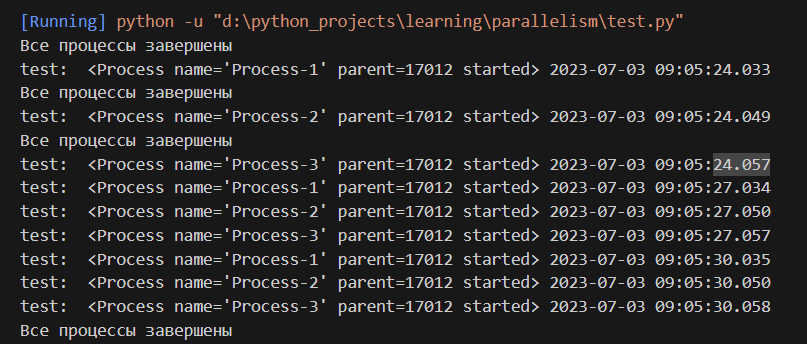

Далее запустим процесс, используя классы.
Для того, чтобы это сделать, нужно переопределить функцию `run`. Это полезно в тех случаях, когда `target` мы не передаем явно.

Пример:

In [ ]:
import multiprocessing


class MyProcess(multiprocessing.Process):

    def run(self) -> None:
        # здесь можно реализовать нужную нам логику и запускать процесс непосредственно из класса
        print('work')


pr = MyProcess()
pr.start()

Result:  
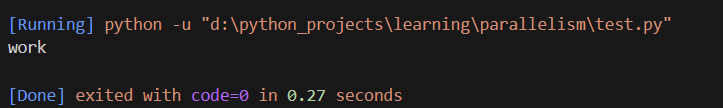

Таким образом, непосредственнно в методе `run`, который мы переопределили, мы можем реализовать нужную нам логику и запускать процесс непосредственно из класса.

### 2.2. Технологии Lock, RLock, Array, Queue

В этом уроке рассмотрим блокировщики, а также `Array` массивы, которые могут давать доступ к одной переменной сразу нескольким процессам.  
`Array` также может использоваться для общения между процессами и обмена информацией.  
Также рассмотрим очереди и то, как их использовать в процессах.

Первое отличие `Lock()` в `threading` и `multiprocessing` заключается в том, что в `multiprocessing` нам нужно явно передавать аргумент `Lock()` в функцию. Используя же `threading` мы просто могли объявить объект `Lock()`, а после обращаться к нему.

Вот пример:

In [ ]:
import multiprocessing


lock = multiprocessing.Lock() # создаем экземпляр объекта Lock()


def get_value(l): # передаем аргумент в функцию
    l.acquire() # обращаемся к экземпляру Lock() через аргумент функции l, блокируем доступ к коду
    pr_name = multiprocessing.current_process().name
    print(f'Процесс: [{pr_name}] запущен', flush=True)


if __name__ == '__main__':
    multiprocessing.Process(target=get_value, args=(lock, )).start() # вызываем класс Process, в инициализатор передаем парамтер args со значением lock
    multiprocessing.Process(target=get_value, args=(lock, )).start()

Result:  
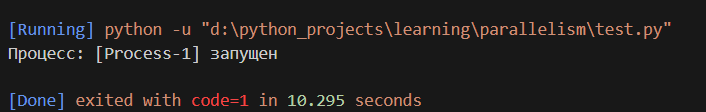

Как видно, когда интерпертатора дошел до `l.acquire()` все процессы приостановились и ожидают `l.release()` для продолжения.  
При этом в любом процессе можно вызывать метод `release()`, не обязательно в том, в котором мы вызвали `l.acquire()`.  
То есть `Lock()` это замок, ключ к которому есть у каждого.

Вот пример с `RLock()`:

In [ ]:
import multiprocessing


lock = multiprocessing.RLock() # создаем экземпляр объекта Lock()


def get_value(l): # передаем аргумент в функцию
    l.acquire() # обращаемся к экземпляру Lock() через аргумент функции l, блокируем доступ к коду
    pr_name = multiprocessing.current_process().name
    print(f'Процесс: [{pr_name}] запущен', flush=True)


if __name__ == '__main__':
    multiprocessing.Process(target=get_value, args=(lock, )).start() # вызываем класс Process, в инициализатор передаем парамтер args со значением lock
    multiprocessing.Process(target=get_value, args=(lock, )).start()

Вывод:  
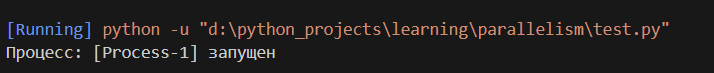

В данном примере `Process-1` дошел до `l.acquire()`, заблокировав выполнение других потоков.  
Второй процесс попытался получить доступ к `pr_name = multiprocessing.current_process().name` и ниже, но не смог, так как блокировка, установленная процессом `Process-1`, еще не снята.

Далее рассмотрим, как использовать `Array` в процессах.  
С помощью `Array` мы можем обмениваться информацией между процессами.  
`Array` является массивом, то есть в него нужно указывать, какой тип данных мы собираемся использовать.

Вот пример:

In [ ]:
import multiprocessing
import random
import time


def add_value(locker, array, index): # создаем функции с параметром для Locker() и Array()
    with locker: # используется контекстный менеджер with для того, чтобы самостоятельно вызывать acquire() и release()
                 # вызывается для того, чтобы только один процесс имел доступ к ячейке памяти, которая хранит индекс и значение массива arr
        num = random.randint(0, 20)
        mtime = time.ctime()
        array[index] = num
        print(f'array[{index}] = {num}, time = {mtime}', flush=True)
        time.sleep(num)


lock = multiprocessing.Lock()
arr = multiprocessing.Array('i', range(10)) # создаем экземпляр класса Array() и передаем тип данных 'i' - Integer
processes = []


if __name__ == '__main__':
    for i in range(10): # создаем 10 процессов
        pr = multiprocessing.Process(target=add_value, args=(lock, arr, i, )) # в каждом из десяти процессов выполняем функцию add_value, которая будет знаосить запись в массив array
        pr.start()
        processes.append(pr)

    for i in processes:
        i.join() # вызывваем метод join() для каждого процесса, чтобы интерпретатор основного процесса не продолжил свое выполнение пока все 10 процессов не будуит завершены

    print('Все процессы выполнены!', flush=True)
    print(f'Массив arr: {list(arr)}')

Result:  
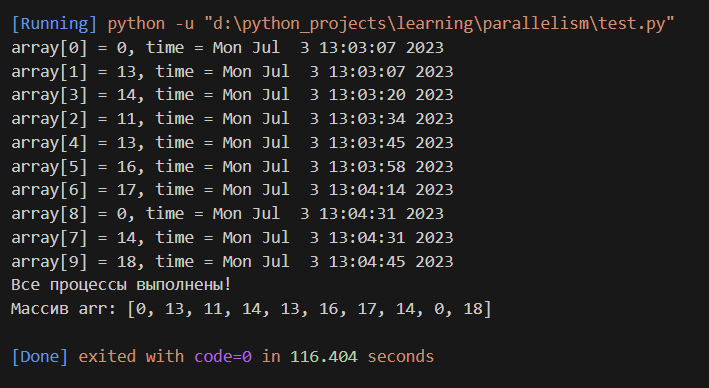

Из примера видно, что из многих процессов мы можем заполнять одну и ту же структуру, а также из одной структуры использовать информацию, чтобы общаться между процессами.  
Например, передавая различные флаги о готовности какого-либо файла.  
Например, когда дргой процесс увидит флаг о том, что файл готов, он сможет принять данный файл и передать его пользователю.

Далее рассмотрим очереди - `Queue()`, которые позволяют передавать данные между процессами.  
`Queue()` позволяют установить максимальное кол-во одновременно выполняемых потоков.

Вот пример:

In [12]:
import multiprocessing


def get_text(q):
    q.put('test') # добавляем значение в очередь, используя метод put()


queue = multiprocessing.Queue() # создаем объект класса Queue()

if __name__ == '__main__':
    pr = multiprocessing.Process(target=get_text, args=(queue, ))
    pr.start()
    print(queue.get()) # получаем значение из очереди
    pr.join()

Вывод:  
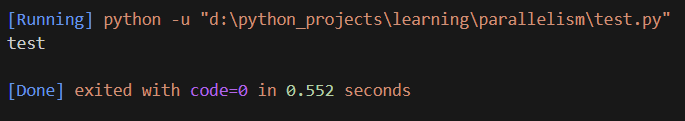

На примере видно, что значение в очередь мы добавляем из созданного нами процесса, но получаем данного значение из основного процесса.  
То есть это говорит о том, что мы можем общаться между процессами, добавлять значение в очередь и получать данные из очереди также из любого процесса.

Еще пример:

In [ ]:
import multiprocessing
import random


def get_text(q):
    value = random.randint(0, 10)
    q.put(str(value)) # добавляем значение в очередь, используя метод put()


queue = multiprocessing.Queue() # создаем объект класса Queue()
pr_list = []

if __name__ == '__main__':
    for _ in range(10): # создаем 10 процессов
        pr = multiprocessing.Process(target=get_text, args=(queue, ))
        pr_list.append(pr)
        pr.start()

    for i in pr_list:
        i.join()

    for elem in iter(queue.get, None): # каждый елемент будет итерируемого объекта будет сравниваться с None
                                       # когда елементы закончатся, постое значение None будет сравнено с None, что приведет к корректному завершению цикла, без ошибки 
        print(elem)

### 2.3. Пулл процессов. Рассматриваем Callback'и и распределяем нагрузку

Пример, как можно использовать `Pul` в процессах:

In [ ]:
import multiprocessing


def get_value(value):
    name = multiprocessing.current_process().name
    print(f'prc: {name}, value: {value}')


if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()*3) as p: # обращаемся к классу Pool()
                                                                   # cpu_count() - количество доуступных ядер нашего процессора
                                                                   # умнножаем количество доступных ядеор на любое разумное число для того, чтобы не сильно нагружать наш процессор
        
        p.map(get_value, [1, 2, 3, 4, 5])                          # map - получает ссылку на функцию и итерируемый объект                                 


Вывод:  
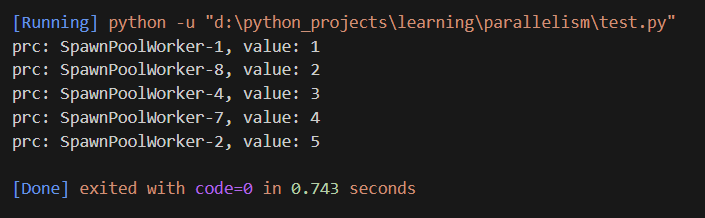

Вот еще пример. Здесь мы запустим больше процессов:

In [ ]:
import multiprocessing


def get_value(value):
    name = multiprocessing.current_process().name
    print(f'prc: {name}, value: {value}')


if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()*3) as p: # обращаемся к классу Pool()
                                                                   # cpu_count() - количество доуступных ядер нашего процессора
                                                                   # умнножаем количество доступных ядеор на любое разумное число для того, чтобы не сильно нагружать наш процессор
        
        p.map(get_value, list(range(100)))                          # map - получает ссылку на функцию и итерируемый объект                                 


Вывод:  
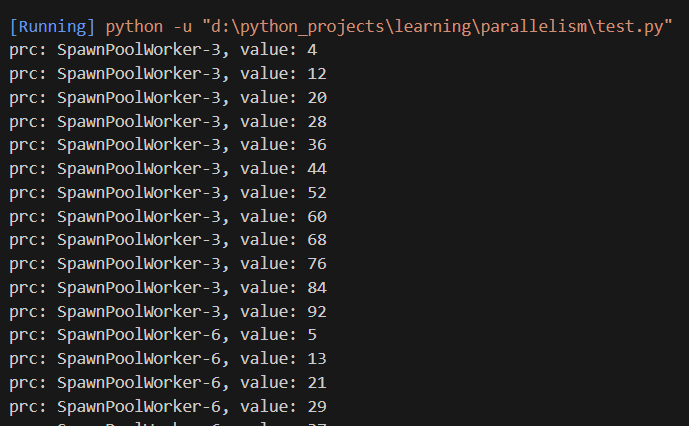

Таким образом, `Pool` нужен для того, чтобы указать количество активных процессов, выполняемыых одновременно.  
При этом, как видно, процессы запускаются не последовательно, а в произвольном порядке.  
Например, `Pool` можно использовать для того, чтобы одновременно парсить страницы на сайте.  
Например, нужно спарсить 1000 страниц - карточек товара. Таким образом, можно обратиться к объекту `Pool`, указав количество процессов и спарсить их одновременно.  
Значение `1000` необходимо передать в `p.map(get_value, list(range(1000)))`

Кроме этого, мы можем использовать `map_async()`, который позволяет после завершения всех наших процессов запустить нужный нам `callback`.
Вот пример:

In [ ]:
import multiprocessing


def end_func(response): # в callback нужно передать response, так как по умолчанию callback возвращает результат выполнения
    print('Задание завершено', flush=True)
    print(response, flush=True)


def get_value(value):
    name = multiprocessing.current_process().name
    print(f'prc: {name}, value: {value}')


if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()*3) as p: # обращаемся к классу Pool()
                                                                   # cpu_count() - количество доуступных ядер нашего процессора
                                                                   # умнножаем количество доступных ядеор на любое разумное число для того, чтобы не сильно нагружать наш процессор
        
        p.map_async(get_value, list(range(100)), callback=end_func) # map_async - получает ссылку на функцию и итерируемый объект, а также callback, который выполнится после выполнения всех процессов
        p.close() # закрываем Pool()
        p.join() # вызываем join(), что позволяет дождаться выполнения всех процессов, переданных в Pool()


Result:  
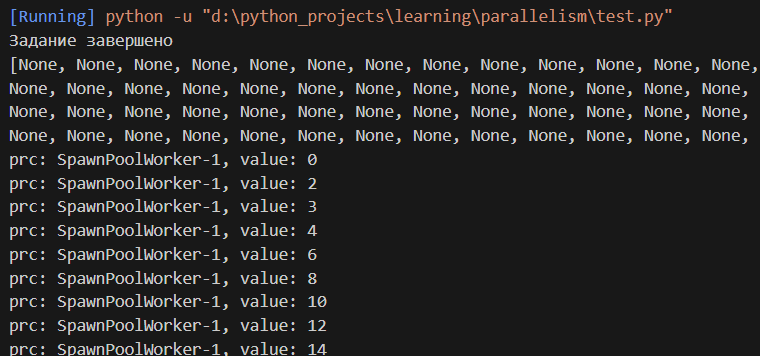

`None, None ...` - список возвращаемых значений.

Для того, чтобы вернуть список из конкретных знаений, нужно в целевой функции указать `return`.
For instance:

In [ ]:
import multiprocessing


def end_func(response):
    print('Задание завершено', flush=True)
    print(response, flush=True)


def get_value(value):
    name = multiprocessing.current_process().name
    print(f'prc: {name}, value: {value}')
    return value


if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()*3) as p:
        p.map_async(get_value, list(range(100)), callback=end_func)
        p.close()
        p.join()


Result:  
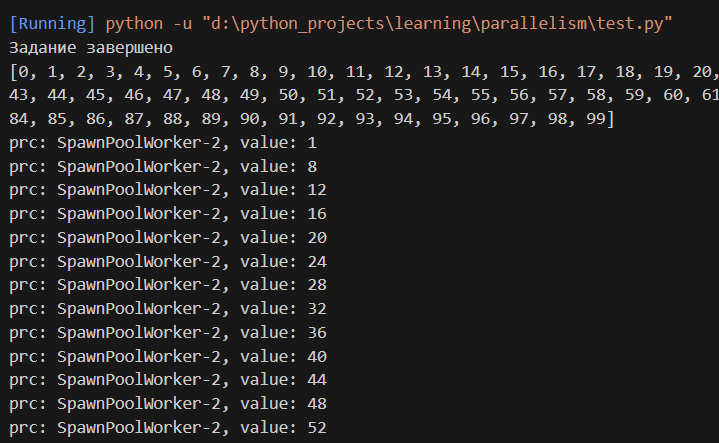

Теперь возвращаемый список содержит заданные элементы.

Далее рассмотрим `apply_asicnc()`, который позволяет вызывать функции отдельно.  
`apply_asicnc()` также позволяет запустить `callback` после того, как одна функция будет выполнена.  
Таким образом, когда у нас выполнится один процесс функции, мы сразу же вызываем `callback()`.

Вот пример:

In [ ]:
import multiprocessing


def end_func(response):
    print(response, flush=True)


def out(x):
    name = multiprocessing.current_process().name
    print(f'prc: {name}, value: {x}')


if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()*3) as p:
        for i in range(10):
            p.apply_async(out, args=(i, ), callback=end_func) # обращаемся к applly_asinc(), в аргумент целевой функции передаем значение итерации
        p.close()
        p.join()


Вывод:  
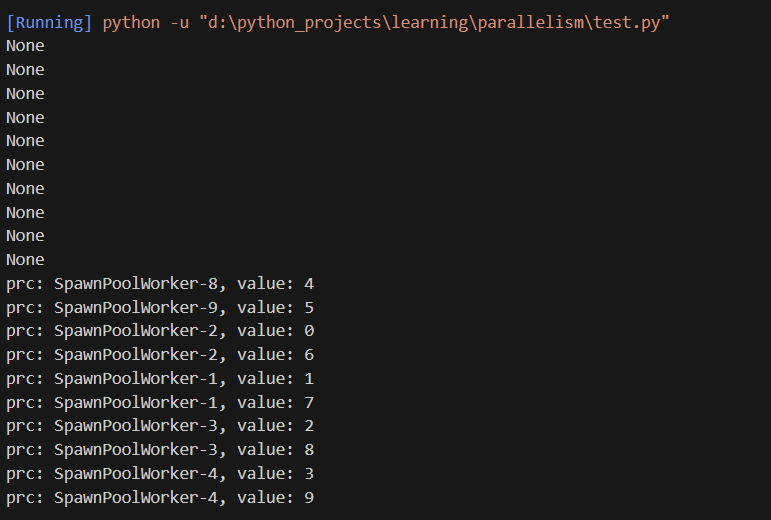

Таким образом, мы получаем вывод, выполняемый в целевой функции `print(f'prc: {name}, value: {x}')`, а также возвращаемые значения в виде `None, None...`, так как в целевую функцию не передан `return`.

Попробуем вернуть значения:

In [ ]:
import multiprocessing


def end_func(response):
    print('end_func', response, flush=True)


def out(x):
    name = multiprocessing.current_process().name
    print(f'prc: {name}, value: {x}')
    return x # возыращаем значения


if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()*3) as p:
        for i in range(10):
            p.apply_async(out, args=(i, ), callback=end_func) # обращаемся к applly_asinc(), в аргумент целевой функции передаем значение итерации
        p.close()
        p.join()


Вывод:  
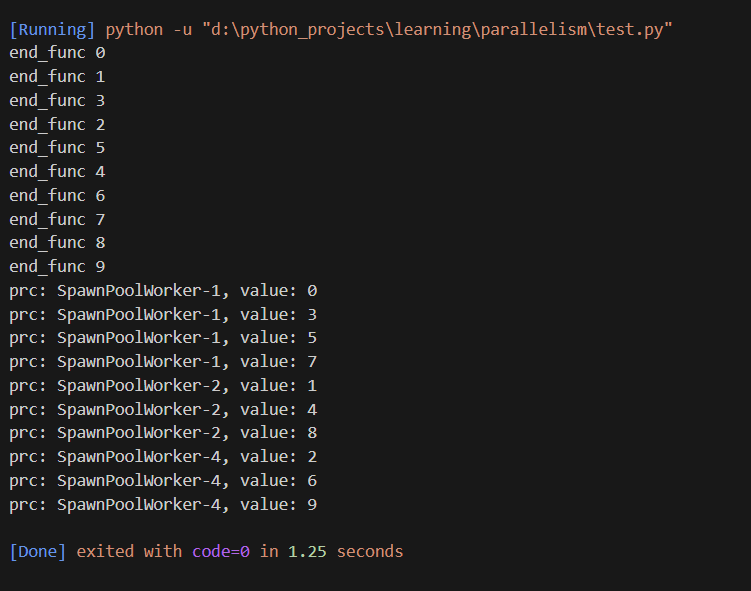

Как видно на примере, `callback` в виде функции `end_func` получает доступ к списку значений, возвращаемых в целевой функции `out`.  

Предположим, нам в целевую функцию нужно передать несколько параметров и вывести несколько значений.  
Вот пример, как это сделать с помощью `starmap`:

In [ ]:
import multiprocessing


# def end_func(response):
#     print('end_func', response, flush=True)


def out(x, y, z):
    name = multiprocessing.current_process().name
    print(f'prc: {name}, value: {x}, {y}, {z}')
    # return x # возdращаем значения


if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()*3) as p:
        p.starmap(func=out, iterable=[(1, 2, 3), (4, 5, 6)]) # starmap принимает целевую функцию, а также список из кортежей
                                                             # каждый кортеж принимает нужное количество аргументов (и сами значения аргументов), передаваемых в целевую функцию
                                                             
        p.close()
        p.join()

Вывод:  
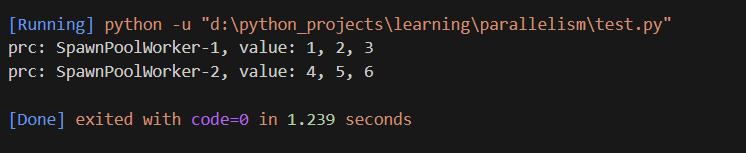

Функция `starmap` работает следующим образом:  
каждый кортеж - новый запуск целевой функции, то есть сколько кортежей, столько и процессов  
Значеня в кортеже присваиваются аргументам целевой функции, например, `x` is `1`, `y` is `2`, `z` is `3` и т.д.

Также у нас есть `starmap_asinc`, который после обработки всех процессов возвращает результат.
Вот пример:

In [ ]:
import multiprocessing


def end_func(response):
    print('end_func', response, flush=True)


def out(x, y, z):
    name = multiprocessing.current_process().name
    print(f'prc: {name}, value: {x}, {y}, {z}')
    return (x, y, z) # возdращаем значения


if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()*3) as p:
        p.starmap_async(func=out, iterable=[(1, 2, 3), (4, 5, 6)], callback=end_func) # starmap принимает целевую функцию, а также список из кортежей
                                                                              # каждый кортеж принимает нужное количество аргументов (и сами значения аргументов), передаваемых в целевую функцию
                                                             
        p.close()
        p.join()

Result:  
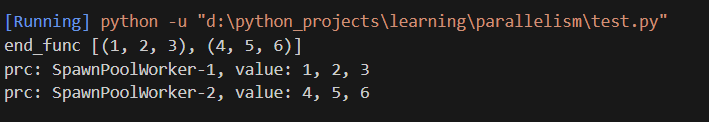

Таким образом, в `callback` попадают все значения, которые возвращает наша целевая функция.

### 2.4. Condition, Event в процессах

Технологии синхронизации `Condition` и `Event` позволяют использовать сигналы и передавать их между процессами.  
Данные технологии позволяют делать общение между процессами и передавать состояние процессов.

`Condition` позволяет использовать состояния, которое помогает остановить выполнение нужного нам процесса в определенном месте.  
Его выполнение не продолжится, пока любой из процессов не сообщит ему об этом.  
В отличие от `Event`, `Condition` может отправлять уведомления всем процессам одновременно, либо только одному определенному процессу.  
`Event` работает по похожему принципу, но имеет два состояния: `False` (ожидание) и `True` (выполнение).

Вот пример работы `Event`:

In [4]:
from multiprocessing import Process, Event
import time


event = Event() # создание экземпляра класса Event()
                # в Event() по умолчанию значение False

def test():
   print('Функция test() запущена', flush=True)
   while True:
        event.wait() # метод wait() останавливает выполнение Event()
                     # процесс сможет выполнить код ниже данного метода только в том случае, когда в Event() установлено значение True
        print('test')
        time.sleep(1)


if __name__ == '__main__':
    Process(target=test).start() # запускаем процесс и передаем адрес на нашу функцию

Вывод:  
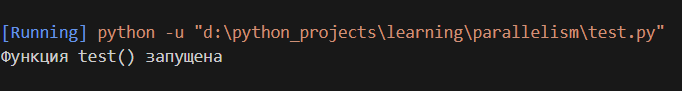

Созданный процесс доходит до `print('Функция test() запущена', flush=True)` и больше ничего не выполняет, так как по умолчанию в `Event()` передается значение `False`.

С помощью метода `event.clear()` можно установить значение `False` в наш `Event()`, с помощью метода `event.set()` можно установить значение `True()` в наш `Event()`.

Вот пример с проверкой `Event()`:

In [ ]:
from multiprocessing import Process, Event
import time


event = Event()


def test(): # данная функция монитрит состояние нашего Event(), то есть работает только тогда, когда установлено значение True
   print('Функция test() запущена', time.localtime(), flush=True)
   while True:
        event.wait()
        print('test event.set()')
        time.sleep(1)


def test_event(): # данная функция будет запущена в отдельном процессе, которая будет устанавливать значение в True, а потом сбрасывать в False
    while True:
        time.sleep(2)
        event.set()
        print('Установлен event.set() для test_event()', time.localtime(), flush=True)

        time.sleep(2)
        event.clear()
        print('Установлен event.clear() для test_event()', time.localtime(), flush=True)


if __name__ == '__main__':
    Process(target=test).start()
    Process(target=test_event).start()

Result:  
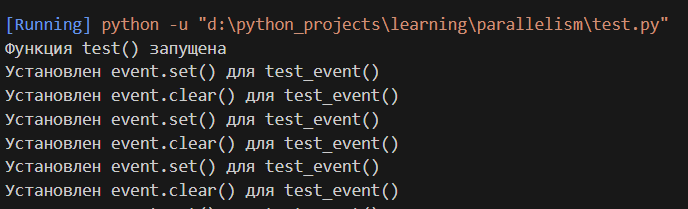

Таким образом, в Pythin 3.11 значение `True` для `Event()` одного процесса нельзя передать в другом процессе.

Далее рассмотрим `Condition`, который позволяет более строго контролировать процессы.  
Отличие от `Event()` заключается в том, что `Condition` не сохораняется состояние `True`, и автоматически возвращает его в `False`.  
`Event()` же сохраняет состояние `True` и выполняет код, пока ему не будет передано значение `False`.  
То есть `Condition` в состоянии `True` срабатывает только один раз.

Вот пример:

In [ ]:
from multiprocessing import Process, Condition # импорт Condition
import time


# функция, которая будет использована в Condition()
def f1(condition) -> None:
    while True:
        with condition:
            condition.wait()
            print('Получили событие', flush=True)
            file = open('D:\\python_projects\\learning\\parallelism\\file_test.txt', 'w')
            file.close()


# # функция, которая будет делать разблокировку Condition()
def f2(condition) -> None:
    for i in range(100):
        if i % 10 == 0 and i != 0:
            with condition:
                condition.notify()
        else:
            print(f'f2: {i}', flush=True)
        time.sleep(1)

Вывод:  
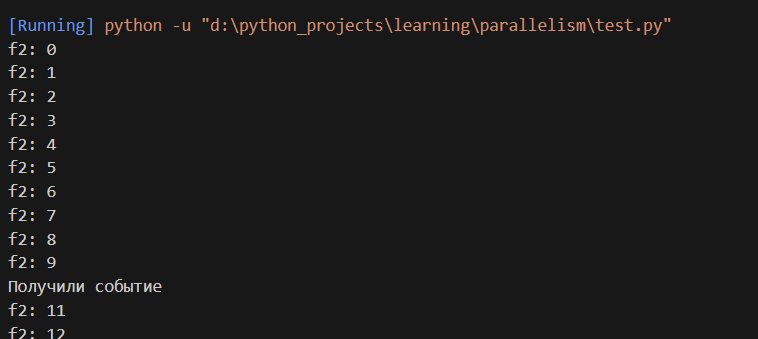

При этом обратите внимание, что объект `Condition()` передается в аргументы функции.

### 2.5. Разбираем Менеджеры, BaseManager, Барьеры

Менеджеры позволяют передавать доступ на определенные функции, то есть делиться объектами памяти.
Вот пример:

In [ ]:
from multiprocessing import Process, Barrier
import multiprocessing


def f1(bar):
    name = multiprocessing.current_process().name
    bar.wait() # заданное кол-во процессов ожидают, пока все не дойдут до этого места
               # когда все процессы (5) дойдут, то начнет выполняться код, который ниже данного метода wait() 
    print(f"[{name}] - запущен")


if __name__ == '__main__':
    b = Barrier(5) # 5 - минимальное количество процессов в барьере
    for i in range(5):
        Process(target=f1, args=(b, )).start()

Вывод:  
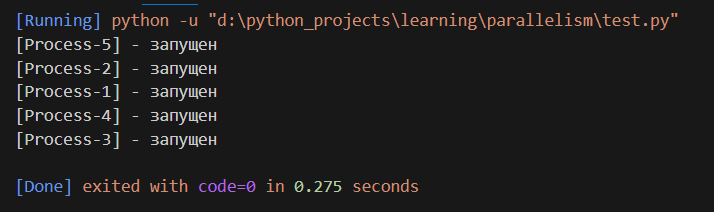

Пока указанное колиечество процессов не дойдет до метода `wait()`, все процессы будут ожидать.  
Когда все процессы дойдут, то начнет выполняться код, который ниже него.

Вот еще пример:

In [ ]:
from multiprocessing import Process, Barrier
import multiprocessing


def f1(bar):
    name = multiprocessing.current_process().name
    sl = random.randint(2, 10)
    print(f"[{name}] - спим {sl} секунд")
    time.sleep(sl)
    bar.wait()
    print(f"[{name}] - запущен")


if __name__ == '__main__':
    b = Barrier(5) # 5 - минимальное количество процессов в барьере
    for i in range(5):
        Process(target=f1, args=(b, )).start()

Вот еще пример:

In [ ]:
from multiprocessing import Process, Barrier
import multiprocessing
import random, time


def f1(bar):
    name = multiprocessing.current_process().name
    sl = random.randint(2, 10)
    print(f"[{name}] - спим {sl} секунд")
    time.sleep(sl)
    bar.wait()
    print(f"[{name}] - запущен")


if __name__ == '__main__':
    b = Barrier(5) # 5 - минимальное количество процессов в барьере
    for i in range(10): # увеличиваем макс. кол-во процессов 
                        # следующие 5 процессов начнут выполняться после того, как будут выполнены предыдущие 5
        Process(target=f1, args=(b, )).start()


Рассмотрим <b>менеджеры</b>.  
Менеджеры позволяют спользовать общую память, задавать разные структуры и передавать все эти структуры между процессами.  
Используя менеджеры мы можем передавать как списки, так и массивы и другиие типы данных.

Вот пример:

In [ ]:
from multiprocessing import Process, Manager


def f(m_dict, m_array):

    # изменяем значения переменных в другом процессе
    m_dict["name"] = "test" 
    m_dict["version"] = "1.0"
    
    m_array.append(1)
    m_array.append(2)


if __name__ == '__main__':
    with Manager() as m:
        d = m.dict() # создаем переменную в основном процессе - list type
        l = m.list() # создаем еще одну переменную в другом процессе - dict type
        pr = Process(target=f, args=(d, l,))
        pr.start()
        pr.join()

        print("dict: ", d)
        print("list: ", l)

Вывод:  
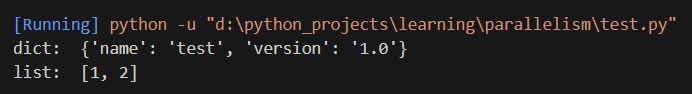

<b>BaseManager</b>.
BaseManager позволяет передавать целые объекты (классы, функции) между процессами.

Вот пример (обработка будет происходить на стороне клиента):

In [ ]:
# server.py
from multiprocessing.managers import BaseManager
import time


def get_time():
    return time.time()


if __name__ == '__main__':
    BaseManager.register("get", callable=get_time) # регистрируем функцию
    manager = BaseManager(address=('', 4444), authkey=b"abc") # передача адреса и порта, которые будут использоваться в качестве сервера
    server = manager.get_server()
    print("Server start")
    server.serve_forever()

In [ ]:
# client.py
from multiprocessing.managers import BaseManager


BaseManager.register("get") # регистрируем функцию
manager = BaseManager(address=("127.0.0.1", 4444), authkey=b"abc")
print("Client connected")
manager.connect()

if __name__ == '__main__':
    res = manager.get()
    print("result", res)

Вывод:  
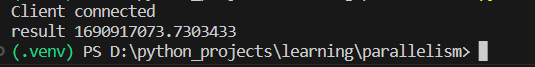

Таким образом, можно создать множество функций, зарегистрировать их и вызывать их по их имени, хотя они могут быть прописаны в другом файле и запущены в другом процессе.

### 2.6. Pipe. Трубы и передача данных между процессами

Технология `Pipe` позволяет передавать данные между процессами и реализовывать общение.  
То есть есть общий канал передачи данных, который позволяет передавать информацию меджу разными процессами.

Вот пример:

In [1]:
from multiprocessing import Pipe

a, b = Pipe() # a - канал для передачи данных
              # b - канал, для получения данных  
a.send([1, "Hello"])

if __name__ == '__main__':
    print(b.recv())

[1, 'Hello']


Также мы можем отправить данные, используя `b`, и получиьт данные, используя `a`:

In [2]:
from multiprocessing import Pipe

a, b = Pipe() # a - канал для передачи данных
              # b - канал, для получения данных  
b.send([1, "Hello"])

if __name__ == '__main__':
    print(a.recv())

[1, 'Hello']


Вот еще пирмер:

In [ ]:
from multiprocessing import Pipe, Process
import multiprocessing


def send_data(conn):
    ''' отправка данных из отдельного процесса '''
    conn.send("Hello world")
    conn.close() # закрываем канал


if __name__ == '__main__':
    outpite_c, inpute_c = Pipe()
    p = multiprocessing.Process(target=send_data, args=(inpute_c, )) # создание отдельного процесса
    p.start()
    p.join()
    print("data: ", outpite_c.recv()) # получение данных из основного процесса

Вывод:  
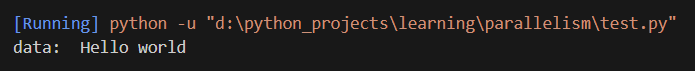

Вот еще пример:

In [ ]:
from multiprocessing import Pipe, Process
import multiprocessing


def send_data(conn):
    ''' отправка данных из отдельного процесса '''
    conn.send("Hello world")
    # conn.close() # закрываем канал


if __name__ == '__main__':
    outpite_c, inpute_c = Pipe()
    multiprocessing.Process(target=send_data, args=(inpute_c, )).start() # создание отдельного процесса
    multiprocessing.Process(target=send_data, args=(inpute_c, )).start() # создание отдельного процесса
    print("data: ", outpite_c.recv(), flush=True) # получение данных из основного процесса
    print("data: ", outpite_c.recv(), flush=True) # получение данных из основного процесса
    print("data: ", outpite_c.recv(), flush=True) # получение данных из основного процесса

Вывод:  
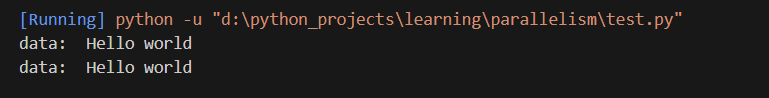  
Как видно, всего два вывода, так как на третьем `print` в переменной отсутствует какое-либо значение.

Вот еще пример:

In [ ]:
from multiprocessing import Pipe, Process
import multiprocessing


def send_data(conn):
    ''' отправка данных из отдельного процесса '''
    conn.send("Hello world")
    conn.send("Hello world")
    # conn.close() # закрываем канал


if __name__ == '__main__':
    outpite_c, inpute_c = Pipe()
    multiprocessing.Process(target=send_data, args=(inpute_c, )).start() # создание отдельного процесса
    multiprocessing.Process(target=send_data, args=(inpute_c, )).start() # создание отдельного процесса
    print("data: ", outpite_c.recv(), flush=True) # получение данных из основного процесса
    print("data: ", outpite_c.recv(), flush=True) # получение данных из основного процесса
    print("data: ", outpite_c.recv(), flush=True) # получение данных из основного процесса
    print("data: ", outpite_c.recv(), flush=True) # получение данных из основного процесса

Вывод:  
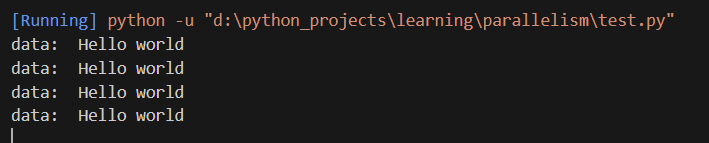  
Как видно, четыре выводе, так как четыре раза было направлено значение в канал.

При этом, если закрыть канал перед отправкой значения, можно полуить ошибку:

In [ ]:
from multiprocessing import Pipe, Process
import multiprocessing


def send_data(conn):
    ''' отправка данных из отдельного процесса '''
    conn.close() # закрываем канал
    conn.send("Hello world")
    conn.send("Hello world")
    

if __name__ == '__main__':
    outpite_c, inpute_c = Pipe()
    multiprocessing.Process(target=send_data, args=(inpute_c, )).start() # создание отдельного процесса
    multiprocessing.Process(target=send_data, args=(inpute_c, )).start() # создание отдельного процесса
    print("data: ", outpite_c.recv(), flush=True) # получение данных из основного процесса
    print("data: ", outpite_c.recv(), flush=True) # получение данных из основного процесса
    print("data: ", outpite_c.recv(), flush=True) # получение данных из основного процесса
    print("data: ", outpite_c.recv(), flush=True) # получение данных из основного процесса

Вывод:  
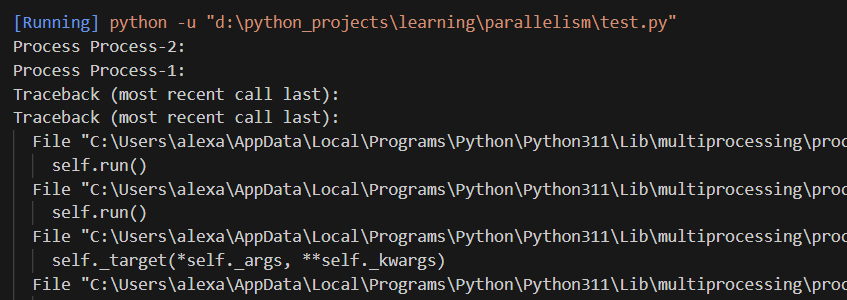 

Создадим две функции:

In [ ]:
from multiprocessing import Pipe, Process
import multiprocessing


def send_data(conn):
    ''' отправка данных из отдельного процесса '''
    conn.close() # закрываем канал
    conn.send("Hello world")


def send_data2(conn):
    ''' отправка данных из отдельного процесса '''
    conn.send("Data 2")
    conn.close() # закрываем канал
    

if __name__ == '__main__':
    outpite_c, inpute_c = Pipe()
    multiprocessing.Process(target=send_data, args=(inpute_c, )).start() # создание отдельного процесса
    multiprocessing.Process(target=send_data2, args=(inpute_c, )).start() # создание отдельного процесса
    print("data: ", outpite_c.recv(), flush=True) # получение данных из основного процесса
    print("data: ", outpite_c.recv(), flush=True) # получение данных из основного процесса

Вывод:  
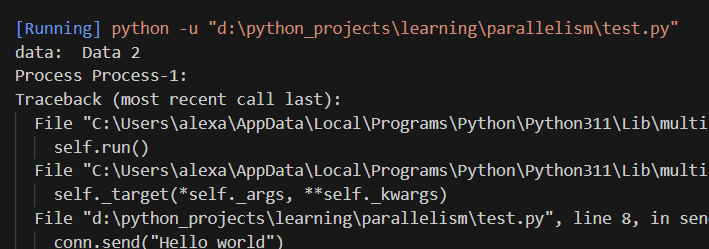  
Как видно, один процесс отработал без ошибок, второй процесс завершился с ошибкой, так какнал закрыт прежде, чем мы передаем в него данные.

Вот еще пример:

In [ ]:
from multiprocessing import Pipe, Process
import multiprocessing
import time


def getter(pipe):
    out, inp = pipe
    inp.close() # закрываем переменную, которая служит для передачи данных
                # процесс сможет только читать данные
    while True:
        try:
            print("data: ", out.recv()) # после отправки данных в функции setter данный метод разблокируется и выведет все на экран и перейдет на след. итерацию цикла
        except:
            break


def setter(sequence, inpute_c):
    for item in sequence:
        time.sleep(1)
        inpute_c.send(item) # отправляем последовательность данных во входящий канал
    

if __name__ == '__main__':
    outpute_c, inpute_c = Pipe()
    g = multiprocessing.Process(target=getter, args=((outpute_c, inpute_c), )) # создание отдельного процесса
    g.start()
    outpute_c.close() # закрываем переменную в основном процессе
    
    setter([1, 2, 3, 4, 5], inpute_c)
    inpute_c.close()
    g.join() # дожидаемся выполнения основного процесса

Вывод:  
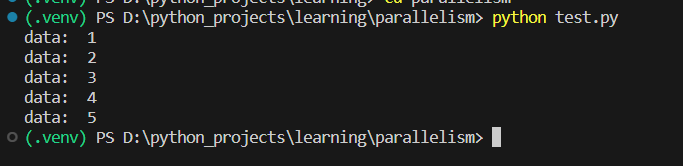